In [11]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
# from torch.utils.data import DataLoader
# from torchvision import datasets
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from time import time


In [12]:
class Config:
    faces_dir = 'faces'
    embeddings_csv = 'embeddings_template.csv'
    recognition_threshold = 0.6
    text_params = (cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, 2)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    workers = 0 if os.name == 'nt' else 4
print('Running on device: {}'.format(Config.device))

Running on device: cpu


In [13]:
class FaceRecognizer:
    def __init__(self, embdeddings_csv = 'embeddings_template.csv', mtcnn = None, resnet = None):
        """
        Args:
        embdeddings_csv (str): path to csv file with embeddings
        mtcnn (MTCNN): MTCNN object
        resnet (InceptionResnetV1): InceptionResnetV1 object
        
        """
        if mtcnn is not None:
            self.mtcnn = mtcnn
        else:
            self.mtcnn = MTCNN(
            image_size=160, margin=0, min_face_size=20,
            thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
            device=Config.device,
            keep_all=True
            )
        if resnet is not None:
            self.resnet = resnet
        else:
            self.resnet = InceptionResnetV1(pretrained='vggface2').eval().to(Config.device)
        self.emb_csv = embdeddings_csv

    def init_df(self, empty = False):
        if not empty:
            with torch.no_grad():
                img = Image.open('faces/andruckiy_style.jpg')
                face = self.mtcnn(img, return_prob=False)
                emb = (self.resnet(face).numpy())
                new_row = {
                            'person_id': 0,
                            'name': 'ivanka',
                            }
                for j in range(512):
                    new_row[str(j)] = emb[0][j]
                self.df = pd.DataFrame(new_row, index=[0])
        else:
            columns = ['person_id', 'name'] + [str(i) for i in range(512)]
            self.df = pd.DataFrame(columns=columns)
        self.df.to_csv(self.emb_csv, index=False)
        #display(df)
        return self.df

    def embed_all_faces_in_folder(self, folder_path, person_id, person_name):
        for file_name in os.listdir(folder_path):
            img = Image.open(os.path.join(folder_path, file_name))
            with torch.no_grad():
                try:
                    faces = self.mtcnn(img, return_prob=False)
                except:
                    print('Error processing image ' + folder_path + '/' + file_name)
                    continue
                if faces is None or len(faces) == 0:
                    print('No faces found in image ' + folder_path + '/' + file_name)
                    continue
                for i in range(len(faces)):
                    emb = (self.resnet(faces[i].unsqueeze(0)).numpy())
                    new_row = {
                    'person_id': person_id,
                    'name': person_name,
                    }
                    for j in range(512):
                        new_row[str(j)] = emb[0][j]
                    new_row = pd.DataFrame(new_row, index=[0])
                    self.df = pd.concat([self.df, new_row], ignore_index=True)
            print('added ' + str(len(faces)) + ' embeddings for image ' + folder_path + '/' + file_name)
        self.df.to_csv(self.emb_csv, index=False)
        return self.df

    def read_camera(self):
        cam = cv2.VideoCapture(0)
        df = pd.read_csv(self.emb_csv)
        face_detected_time = None

        with torch.no_grad():
            while True:
                ret, frame = cam.read()
                if not ret:
                    break

                frame = cv2.flip(frame, 1)
                frame_copy = frame.copy()
                
                #DETECT FACES AND DRAW RECTANGLES
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                if boxes is not None:
                    for i in range(len(boxes)):
                        cv2.rectangle(frame_copy, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])), (250, 250, 250), 2)

                k = cv2.waitKey(1) & 0xFF

                # #SAVE EMBEDDINGS
                # if k == ord(' '):
                #     cv2.putText(frame_copy,'EMBEDDING', 
                #         (10, 40), 
                #         *Config.text_params)
                #     faces, _ = mtcnn(frame_copy, return_prob=True)
                    
                #     if faces is not None and len(faces) > 0:
                #         #plt.imshow(faces[0].permute(1, 2, 0).int().numpy())
                #         print("num of faces on screen: " + str(len(faces)))
                #         #print(faces[0].shape)
                #         emb = []
                #         for i in range(len(faces)):
                #             emb.append(resnet(faces[i].unsqueeze(0)).numpy())
                #             #print("emb[i]: "+ str(emb[i]))
                #             new_row = {
                #             'person_id': 99,
                #             'name': 'no',
                #             }
                #             for j in range(512):
                #                 new_row[str(j)] = emb[i][0][j]
                #             #print("emb[i][0][0]: "+ str(emb[i][0][0]))
                #             new_row = pd.DataFrame(new_row, index=[0])
                #             df = pd.concat([df, new_row], ignore_index=True)
                #         #print(df)
                #         print('added ' + str(len(faces)) + ' embeddings')
                #         df.to_csv('embeddings.csv', index=False)
                #         #print('EMBEDDINGS SAVED')
            
            #RECOGNIZING
                cv2.putText(frame_copy,'RECOGNIZING', 
                    (10, 40),
                    *Config.text_params)
                
                faces, _ =  self.mtcnn(frame_copy, return_prob=True)
                
                if faces is not None and len(faces) > 0:
                    if face_detected_time is None:
                        face_detected_time = time()
                    elif time() - face_detected_time > 5:
                        cv2.putText(frame_copy,'Hello, stranger!', 
                            (10, 70), 
                            *Config.text_params)
                    embeddings = df.iloc[:, 2:514].values
                    for i in range(len(faces)):
                        emb = (self.resnet(faces[i].unsqueeze(0)).numpy())
                        dists = [1 - (np.dot(emb, e)) for e in embeddings] #cosine distance
                        min_id = np.argmin(dists)
                        if dists[min_id] < Config.recognition_threshold: #recognized
                            cv2.putText(frame_copy, df.iloc[min_id, 1], 
                                (int(boxes[i][0]), int(boxes[i][1])), 
                                *Config.text_params)
                            cv2.putText(frame_copy, str(dists[min_id]), 
                                (int(boxes[i][0]) - 30, int(boxes[i][1]) - 30), 
                                *Config.text_params)
                        else: #didn't recognize
                            cv2.putText(frame_copy,'unknown', 
                                (int(boxes[i][0]), int(boxes[i][1])), 
                                *Config.text_params)
                else:
                    face_detected_time = None

                cv2.imshow("camera",frame_copy)
                if k == 27:
                    cam.release()
                    cv2.destroyAllWindows()
                    break


        #Release the camera and destroy all the windows
        #display(df)
        cam.release()
        cv2.destroyAllWindows()

In [14]:
recognizer = FaceRecognizer()
df = recognizer.init_df(empty = True)
df = recognizer.embed_all_faces_in_folder('faces/ivanka', 0, 'ivanka')
df = recognizer.embed_all_faces_in_folder('faces/rachel', 1, 'rachel')
df = recognizer.embed_all_faces_in_folder('faces/ross', 2, 'ross')
df = recognizer.embed_all_faces_in_folder('faces/mads_mikkelsen', 3, 'mads mikkelsen')
df = recognizer.embed_all_faces_in_folder('faces/will_graham', 4, 'will graham')
df = recognizer.embed_all_faces_in_folder('faces/alana_bloom', 5, 'alana bloom')
df = recognizer.embed_all_faces_in_folder('faces/Yanochka', 6, 'Yanochka')
# df = recognizer.embed_all_faces_in_folder('faces/polina', 6, 'polina')
df

C:\Users\User\AppData\Local\Temp\ipykernel_12020\2140149998.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, new_row], ignore_index=True)


added 1 embeddings for image faces/ivanka/in_headphones.jpg
added 1 embeddings for image faces/ivanka/in_makeup.jpg
added 1 embeddings for image faces/ivanka/in_the_mirror.jpg
added 1 embeddings for image faces/ivanka/on_the_beach.jpg
added 1 embeddings for image faces/ivanka/posvyata.jpg
added 1 embeddings for image faces/ivanka/with_prize.jpg
added 1 embeddings for image faces/rachel/01.jfif
added 1 embeddings for image faces/rachel/02.jpg
added 1 embeddings for image faces/rachel/03.jpg
added 1 embeddings for image faces/rachel/04.jpg
added 1 embeddings for image faces/ross/01.jpg
added 1 embeddings for image faces/ross/02.jpg
added 1 embeddings for image faces/ross/03.jpg
added 1 embeddings for image faces/ross/05.jfif
added 1 embeddings for image faces/mads_mikkelsen/01.jfif
added 1 embeddings for image faces/mads_mikkelsen/02.jpg
added 1 embeddings for image faces/mads_mikkelsen/03.jfif
added 1 embeddings for image faces/mads_mikkelsen/04.jpg
added 1 embeddings for image faces/wi

,person_id,name,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,0,ivanka,-0.055515,-0.044367,0.045084,0.155886,0.049426,-0.030203,-0.119557,0.006104,...,-0.030466,0.039107,0.006168,0.076495,0.042928,-0.033484,0.001808,-0.020012,0.029459,-0.082452
1,0,ivanka,-0.090156,0.065855,-0.027744,-0.015429,0.069158,-0.025611,-0.032440,-0.007514,...,-0.034812,-0.044515,-0.019001,-0.020669,-0.013088,-0.026981,0.034084,0.021951,0.082649,-0.027518
2,0,ivanka,-0.061711,0.020516,0.013416,0.058102,0.052804,-0.015202,-0.042920,0.025144,...,0.055044,-0.008051,0.013532,0.086159,0.097312,0.010626,0.010787,-0.025640,0.021403,-0.057742
3,0,ivanka,-0.055528,0.040419,-0.007679,0.003316,0.073610,-0.039539,-0.070186,0.037557,...,-0.011947,-0.083628,-0.033235,0.043123,-0.018910,-0.062889,0.028366,-0.042391,0.057680,0.017885
4,0,ivanka,-0.033264,0.014510,0.003187,-0.031831,0.004414,-0.057279,-0.031851,0.067878,...,-0.054275,-0.058807,-0.033748,0.031714,-0.032633,-0.026138,0.044386,-0.014058,0.036948,-0.023456
5,0,ivanka,0.001519,-0.062387,-0.097134,0.034222,0.000097,-0.049740,-0.006512,0.006501,...,-0.087875,0.065682,-0.086228,0.085164,0.001333,-0.053257,-0.035873,0.002294,0.014930,-0.021468
6,1,rachel,0.054729,0.001943,0.017714,0.054034,0.077800,-0.044774,-0.031662,-0.036841,...,-0.077906,0.041292,0.035977,-0.035231,-0.000092,-0.012505,-0.007913,0.008053,0.030045,-0.104833
7,1,rachel,0.001685,0.038192,0.074783,0.035592,0.009465,0.056762,-0.034974,-0.024774,...,-0.026897,0.000902,-0.020072,-0.086589,0.049660,-0.048892,0.034854,0.053710,0.011987,-0.023094
8,1,rachel,0.044563,0.026494,0.010428,0.012469,0.042833,0.026745,-0.034384,-0.041007,...,-0.070006,-0.030733,-0.029961,-0.092533,-0.029550,-0.053136,-0.052797,-0.008230,0.017417,-0.021940
9,1,rachel,0.008325,-0.001755,0.014757,0.048124,0.015657,-0.005151,-0.045184,-0.085582,...,-0.037075,0.048898,0.001549,-0.056025,-0.035851,-0.030430,-0.001825,-0.021967,0.017606,-0.048271


In [15]:
def calculate_distances(df):
    embeddings = df.iloc[:, 2:514].values
    dists = [[1 - (np.dot(e1, e2)) for e2 in embeddings] for e1 in embeddings]    #cosine distances
    dists_df = pd.DataFrame(dists, columns = df.index.values, index = df.index.values)
    return dists_df


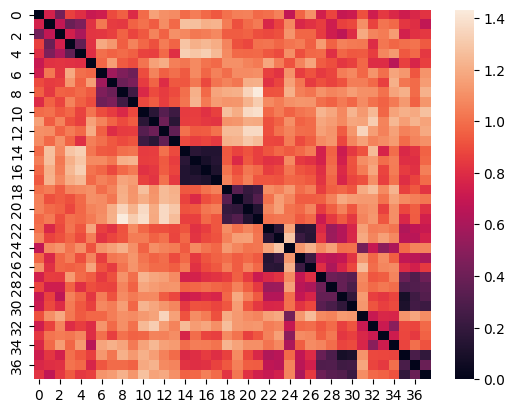

In [16]:
import seaborn as sns
sns.heatmap(calculate_distances(df))
plt.show()

In [18]:
recognizer.read_camera()

KeyboardInterrupt: 